In [2]:
!pip install roboflow inference-sdk torch torchvision opencv-python ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 92.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 34.7 MB/s eta 0:00:0000:0100:01

In [ ]:
from roboflow import Roboflow

from random import sample
import os
import shutil
from pathlib import Path
import yaml

from ultralytics import YOLO

import matplotlib.pyplot as plt
import cv2
import torch

# Download datasets

In [3]:
rf = Roboflow(api_key="API_KEY")

project_banknotes = rf.workspace("unital").project("banknotes-qoenu")
version_banknotes = project_banknotes.version(5)
dataset_banknotes = version_banknotes.download("yolov8")

project_coins = rf.workspace("pachita").project("russian-ruble-coin")
version_coins = project_coins.version(1)
dataset_coins = version_coins.download("yolov8")   

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Banknotes-5 in yolov8:: 100%|██████████| 1584/1584 [00:00<00:00, 10159.82it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Russian-Ruble-coin-1 in yolov8:: 100%|██████████| 568/568 [00:00<00:00, 8632.44it/s]


## Display photos

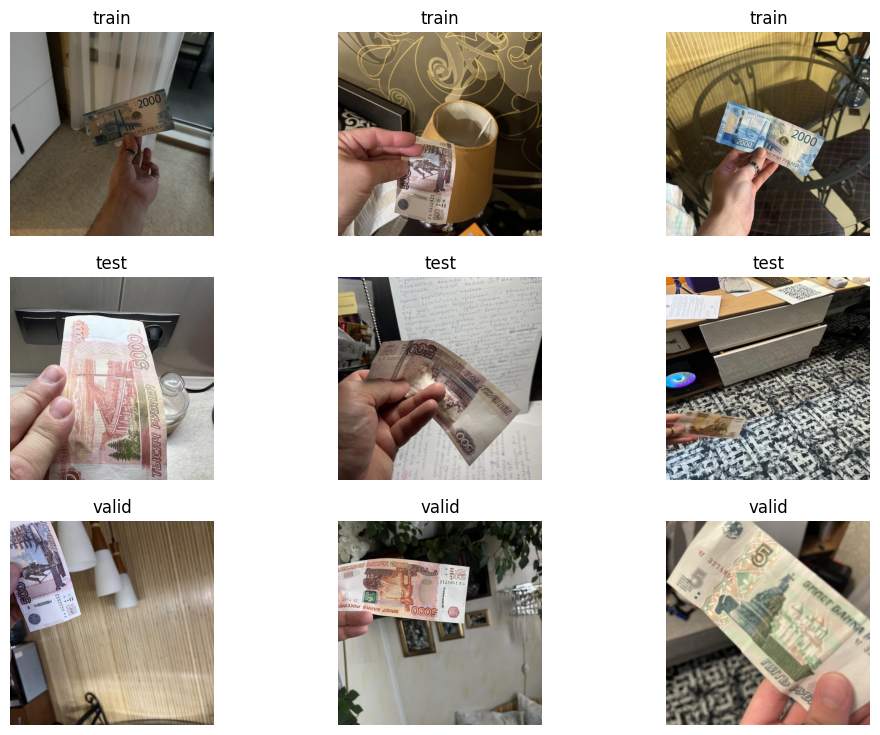

In [95]:
sets = ["train", "test", "valid"]

img_sets = [sample(list((Path("Banknotes-5") / s / "images").iterdir()), k=3) for s in sets]

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for row, paths in enumerate(img_sets):
    for col, p in enumerate(paths):
        ax = axes[row, col]
        ax.imshow(Image.open(p))
        ax.set_title(sets[row])
        ax.axis("off")

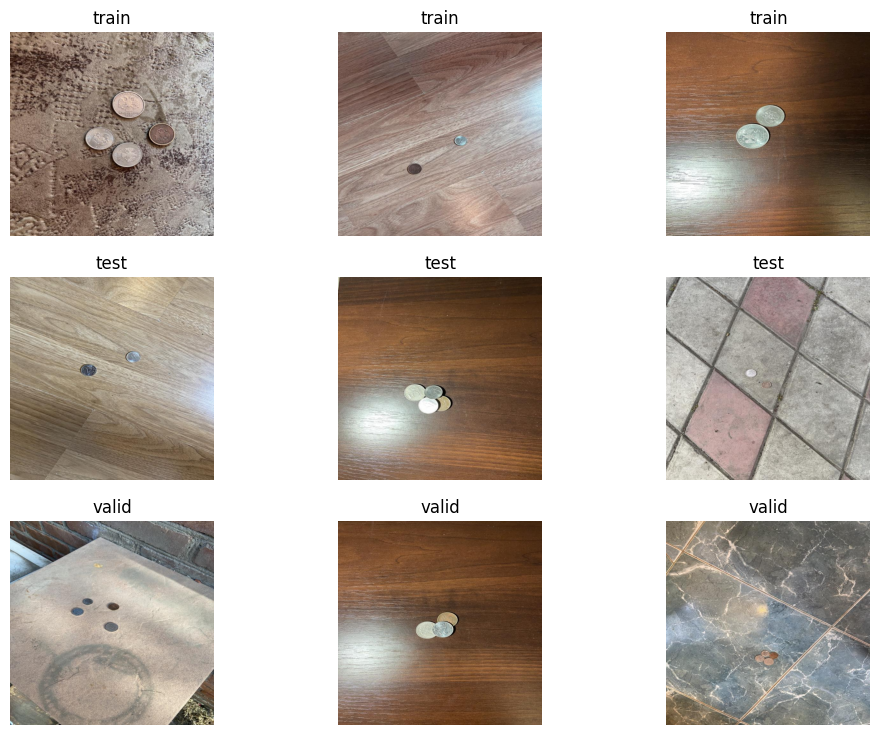

In [96]:
img_sets = [sample(list((Path("Russian-Ruble-coin-1") / s / "images").iterdir()), k=3) for s in sets]

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for row, paths in enumerate(img_sets):
    for col, p in enumerate(paths):
        ax = axes[row, col]
        ax.imshow(Image.open(p))
        ax.set_title(sets[row])
        ax.axis("off")

# Create YAML

## Since we have installed two separate datasets, we need to adjust the yaml file for training the model, we also recode the coin classes

In [4]:
ds_banknotes = "./Banknotes-5"
ds_coins = "./Russian-Ruble-coin-1"

out_dir = Path("./Banknotes-and-coins")
(out_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
(out_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
(out_dir / "valid" / "images").mkdir(parents=True, exist_ok=True)
(out_dir / "valid" / "labels").mkdir(parents=True, exist_ok=True)
(out_dir / "test" / "images").mkdir(parents=True, exist_ok=True)
(out_dir / "test" / "labels").mkdir(parents=True, exist_ok=True)

def load_yaml(path):
    with open(path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)


bank_yaml = load_yaml(os.path.join(ds_banknotes, "data.yaml"))
coin_yaml = load_yaml(os.path.join(ds_coins, "data.yaml"))

bank_classes = [c.replace("b_", "").replace("B_", "").lower() for c in bank_yaml["names"]]
coin_classes = [c.replace("RUB", "").strip() for c in coin_yaml["names"]]

final_classes = [f"b_{c}" for c in bank_classes] + [f"c_{c}" for c in coin_classes]
print("Classes:", final_classes)

bank_offset = 0
coin_offset = len(bank_classes)

def process_split(split, src_dir, dst_dir, class_offset):
    """Копируем изображения и labels, сдвигаем индексы"""
    for img_file in Path(src_dir, split, "images").glob("*.*"):
        shutil.copy(img_file, Path(dst_dir, split, "images", img_file.name))

    for lbl_file in Path(src_dir, split, "labels").glob("*.txt"):
        out_file = Path(dst_dir, split, "labels", lbl_file.name)
        with open(lbl_file, "r") as f_in, open(out_file, "w") as f_out:
            for line in f_in:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, x, y, w, h = parts
                new_cls = int(cls) + class_offset
                f_out.write(f"{new_cls} {x} {y} {w} {h}\n")


for split in ["train", "valid", "test"]:
    process_split(split, ds_banknotes, out_dir, bank_offset)
    process_split(split, ds_coins, out_dir, coin_offset)

data_yaml = {
    "train": r"../train/images",
    "val": r"../valid/images",
    "test": r"../test/images",
    "nc": len(final_classes),
    "names": final_classes
}

with open(out_dir / "data.yaml", "w", encoding="utf-8") as f:
    yaml.dump(data_yaml, f, allow_unicode=True)

Classes: ['b_10', 'b_100', 'b_1000', 'b_200', 'b_2000', 'b_5', 'b_50', 'b_500', 'b_5000', 'c_1', 'c_10', 'c_2', 'c_5']


# Loading the YOLO model

In [5]:
model = YOLO('yolov8n.pt')

# Training the model

In [6]:
results = model.train(data='./Banknotes-and-coins/data.yaml', epochs=50, imgsz=640)

Ultralytics 8.3.200 🚀 Python-3.10.18 torch-2.6.0+cu124 CPU (AMD EPYC 7B13)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./Banknotes-and-coins/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2123.3±648.5 MB/s, size: 58.9 KB)
val: Scanning /kaggle/working/Banknotes-and-coins/valid/labels... 102 images, 9 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 102/102 1.4Kit/s 0.1s
val: New cache created: /kaggle/working/Banknotes-and-coins/valid/labels.cache
Plotting labels to /kaggle/working/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /kaggle/working/runs/detect/train
Starting training f

# Metrics

In [10]:
metrics = model.val(data='./Banknotes-5/data.yaml', split='test')

print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

Ultralytics 8.3.200 🚀 Python-3.10.18 torch-2.6.0+cu124 CPU (AMD EPYC 7B13)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2026.5±435.6 MB/s, size: 56.4 KB)
val: Scanning /kaggle/working/Banknotes-5/test/labels.cache... 78 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 78/78 58.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 2.5it/s 2.0s0.6s
                   all         78         78      0.983      0.955      0.985      0.889
                  b_10          8          8      0.995      0.875      0.944      0.918
                 b_100          6          6      0.996          1      0.995       0.92
                b_1000          8          8      0.937          1      0.995       0.92
                 b_200          7          7          1       0.89      0.995      0.849
                b_2000          5          5      0.978          1      0.995      0.972
                   b_5         12      

# Try the trained model on tests


0: 640x640 1 c_10, 1 c_2, 25.6ms
1: 640x640 1 b_10, 25.6ms
2: 640x640 1 b_200, 25.6ms
3: 640x640 1 c_10, 2 c_2s, 1 c_5, 25.6ms
4: 640x640 1 b_10, 25.6ms
5: 640x640 1 b_50, 25.6ms
6: 640x640 1 b_1000, 25.6ms
7: 640x640 1 c_1, 1 c_10, 2 c_2s, 1 c_5, 25.6ms
8: 640x640 (no detections), 25.6ms
Speed: 1.2ms preprocess, 25.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


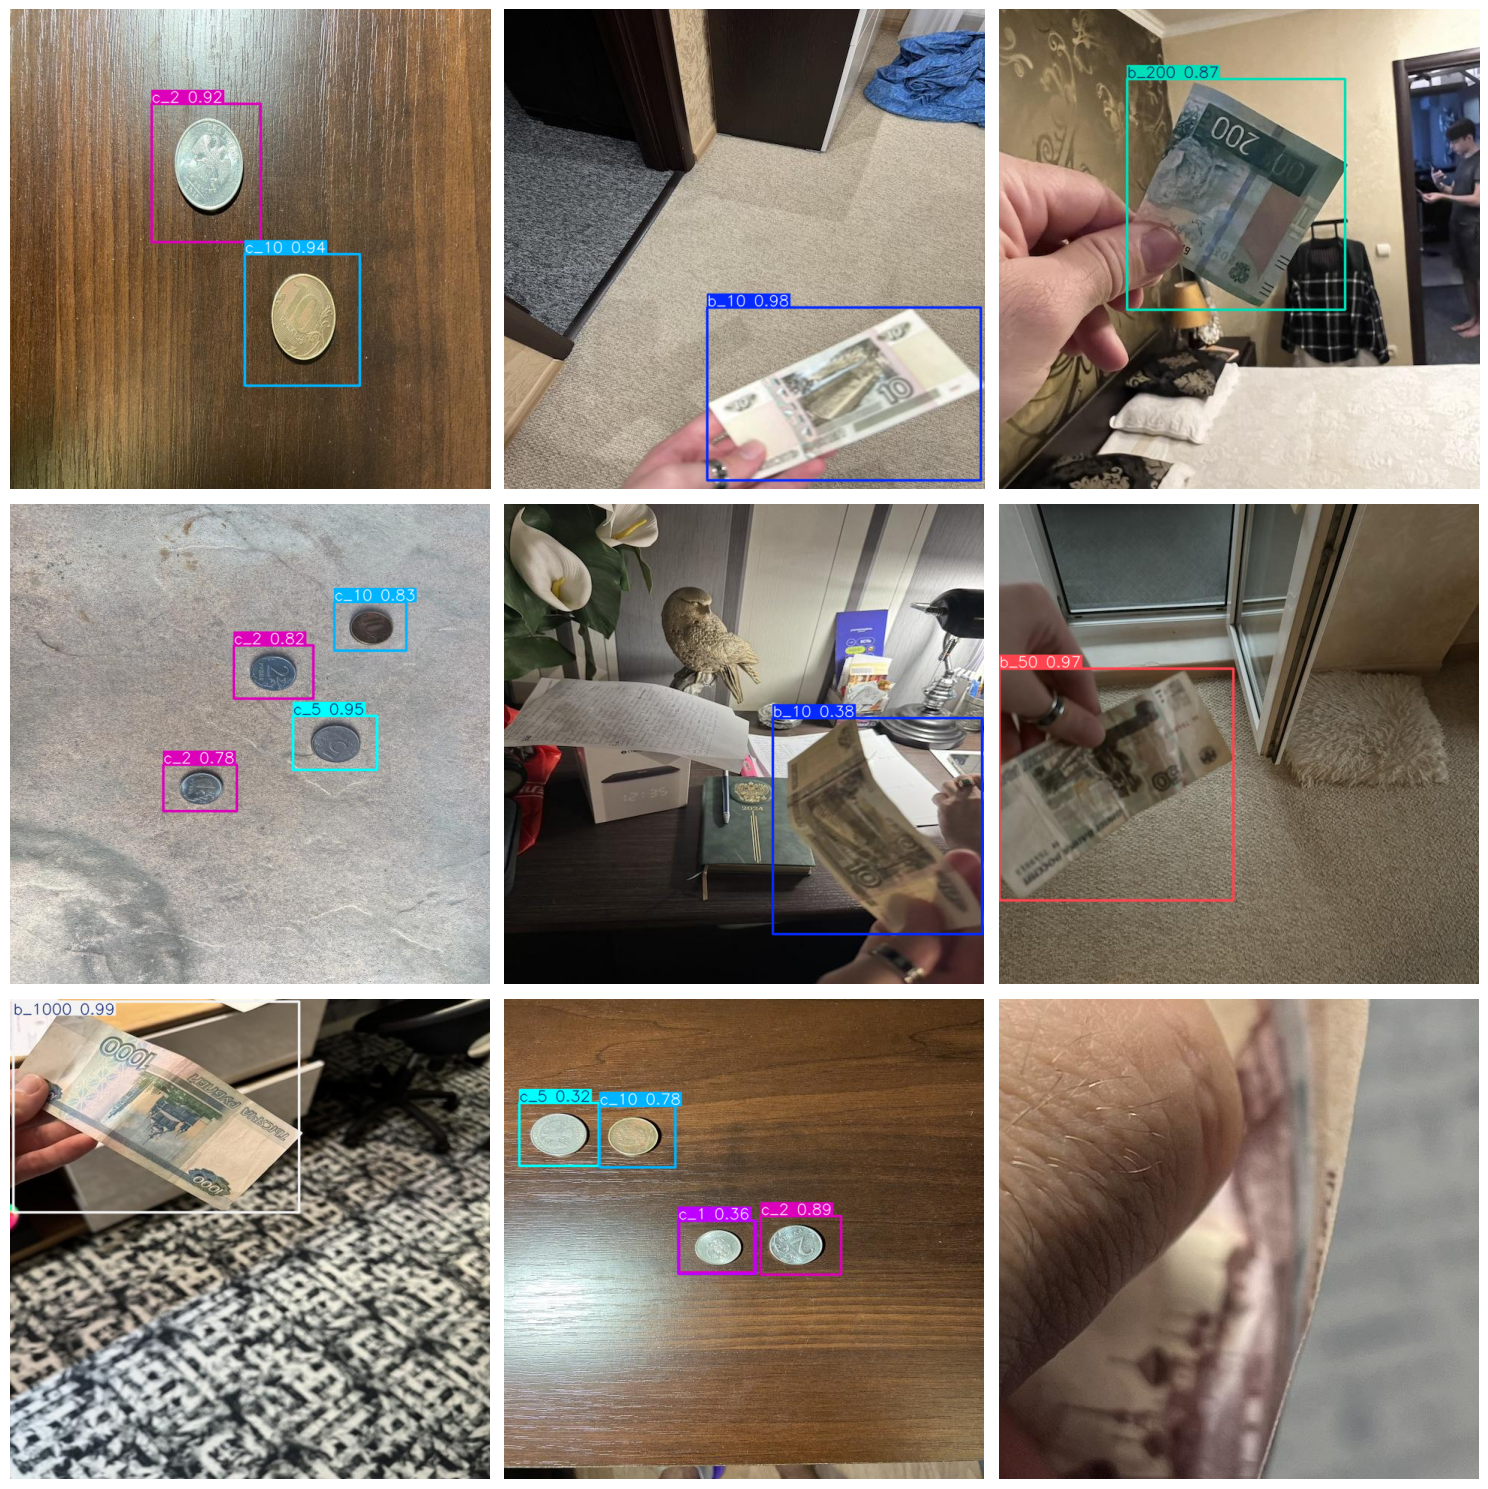

In [97]:
img_dir = Path("./Banknotes-and-coins/test/images")
img_paths = sample(sorted(img_dir.glob("*")), k=9)

results = model(img_paths, conf=0.25, iou=0.45)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for ax, r in zip(axes, results):
    plotted = r.plot()
    ax.imshow(cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB))
    ax.axis("off")

plt.tight_layout()
plt.show()